In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

#provider = IBMQ.get_provider(group='open', project='main')
#backend_real_belem = provider.get_backend('ibmq_lima')



In [ ]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [2]:
n_steps=99
time=np.pi
#initial_state={"110": 1}
#shots = 20000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                    0,                    0,                    0,                    0,                    0,                    0,   0],
[  0,      1.0 + 0.00105*I, 0.000102 + 0.00105*I,                    0, -9.87e-5 - 0.00211*I,                    0,                    0,   0],
[  0, -9.87e-5 + 0.00105*I,      1.0 - 0.00211*I,                    0, 0.000102 + 0.00105*I,                    0,                    0,   0],
[  0,                    0,                    0,      1.0 + 0.00105*I,                    0, -9.87e-5 + 0.00105*I, 0.000102 - 0.00211*I,   0],
[  0, 0.000102 - 0.00211*I, -9.87e-5 + 0.00105*I,                    0,      1.0 + 0.00105*I,                    0,                    0,   0],
[  0,                    0,                    0, 0.000102 + 0.00105*I,                    0,      1.0 - 0.00211*I, -9.87e-5 + 0.00105*I,   0],
[  0,                    0,                    0, -9.87e-5 - 0.00211*I,                    0, 0.000102 + 0.00105*I,      1.0 + 

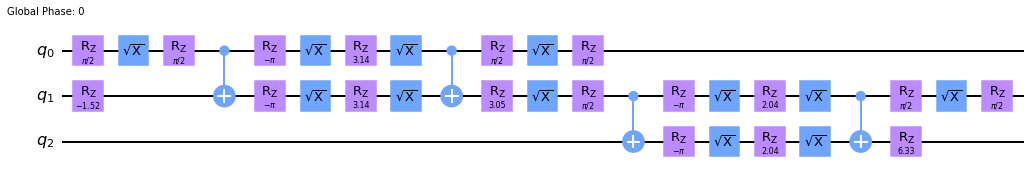

In [3]:
# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [11]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[     0.999999445384491 - 0.00105320022321252*I, -8.53648771296206e-17 - 1.05614965034748e-16*I,  1.18946386785768e-16 - 1.74853216298639e-17*I, -9.72675539219847e-21 + 5.51805468522386e-21*I, -1.54707310042821e-16 + 5.78924961077188e-17*I,   1.36534543547473e-21 + 8.6686009414771e-20*I, -7.57910401783459e-19 - 1.36050280738079e-19*I,                    7.387e-35 + 1.4694713e-33*I],
[  1.87915155531116e-18 - 4.9989803001114e-17*I,      0.999996662238093 - 0.00105319729200031*I,  -0.000114188636672196 + 0.00235653327854652*I, -8.52799071444465e-17 - 2.03121601955678e-17*I,                2.6645948e-33 + 4.4483945e-33*I, -1.35028438662687e-16 + 5.76675080938828e-17*I, -1.14933258718954e-19 - 1.06819677573349e-19*I, -1.69076548795827e-17 - 6.46297676526701e-20*I],
[-1.32262504784171e-16 - 5.40677214634277e-17*I,    9.87301053275835e-5 + 0.00105319729199968*I,       0.447924778093985 - 0.0197207618220178*I,  6.08663043550539e-18 - 3.27581975506579e-17*I,    -0.893852605022019 + 0.

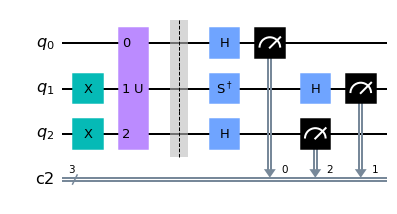

In [20]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [4]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [ ]:
cal_circ[0].draw()

░ ┌─┐      
q7718_0: ─░─┤M├──────
          ░ └╥┘┌─┐   
q7718_1: ─░──╫─┤M├───
          ░  ║ └╥┘┌─┐
q7718_2: ─░──╫──╫─┤M├
          ░  ║  ║ └╥┘
  c97: 3/════╩══╩══╩═
             0  1  2

In [ ]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [ ]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [ ]:
calib_circuits_identity[3].draw()

┌────┐┌───┐┌─┐   
q7726_0: ┤0   ├┤ X ├┤M├───
         │    │├───┤└╥┘┌─┐
q7726_1: ┤1 U ├┤ X ├─╫─┤M├
         │    │└┬─┬┘ ║ └╥┘
q7726_2: ┤2   ├─┤M├──╫──╫─
         └────┘ └╥┘  ║  ║ 
 c105: 3/════════╩═══╩══╩═
                 2   0  1

In [ ]:
calib_circuits_itself[1].draw()

┌───┐┌────┐┌─┐      
q7721_0: ┤ X ├┤0   ├┤M├──────
         └───┘│    │└╥┘┌─┐   
q7721_1: ─────┤1 U ├─╫─┤M├───
              │    │ ║ └╥┘┌─┐
q7721_2: ─────┤2   ├─╫──╫─┤M├
              └────┘ ║  ║ └╥┘
 c100: 3/════════════╩══╩══╩═
                     0  1  2

In [ ]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[0,1,2])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[0,1,2])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[0,1,2])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[0,1,2])

In [ ]:
qiskit_raw_cal = deepcopy(job_cal_qiskit.result().get_counts())

In [5]:
tomo_id = "625067675ab79b0c89f95ef3"
identity_id = "6250676aa5d4ee508477d9fc"
itself_id = "6250676bfdf3777ad456ff20"
qiskit_id = "6250676dcaa265abb0f1a6fe"

job_tomo = backend_real_jakarta.retrieve_job(tomo_id)
job_cal_our_identity = backend_real_jakarta.retrieve_job(identity_id)
job_cal_our_itself = backend_real_jakarta.retrieve_job(itself_id)
job_cal_qiskit = backend_real_jakarta.retrieve_job(qiskit_id)


# Mitigation:

    - building the calibration matrices

In [6]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [ ]:
Matrix(meas_fitter_qiskit.cal_matrix).n(3, chop=True)

Matrix([
[   0.922,   0.0487,   0.0508,  0.00287,    0.046,  0.00272,  0.00231,       0],
[  0.0222,    0.901, 0.000906,   0.0486,  0.00125,   0.0437,  9.37e-5, 0.00294],
[ 0.00722, 0.000281,    0.886,   0.0499, 0.000437,        0,   0.0427, 0.00244],
[0.000125,  0.00506,   0.0187,    0.854,        0, 0.000344, 0.000781,  0.0423],
[   0.047,  0.00256,  0.00231, 0.000125,    0.923,   0.0494,   0.0505, 0.00313],
[0.000844,   0.0422,  6.25e-5,  0.00222,   0.0229,    0.898,  0.00113,  0.0485],
[0.000406,        0,   0.0405,  0.00225,  0.00606,  0.00025,    0.882,  0.0485],
[       0, 0.000281, 0.000656,   0.0397,  9.37e-5,  0.00541,     0.02,   0.852]])

In [ ]:
not_migigated_qiskit = occurrences_to_matrix(qiskit_raw_cal)
Matrix(not_migigated_qiskit).n(3, chop=True)

NameError: name 'qiskit_raw_cal' is not defined

In [ ]:
#calib = np.linalg.multi_dot([migigated_qiskit, np.linalg.inv(not_migigated_qiskit)])
#Matrix(calib).n(2, chop=True)

In [7]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [8]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [9]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q18_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
        ░ └─┬─┬─┘ └───┘      └╥┘   
q18_1: ─░───┤M├───────────────╫────
        ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q18_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
        ░    ║   └─────┘└───┘ ║ └╥┘
 c1: 3/══════╩════════════════╩══╩═
             1                0  2

In [12]:
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

U_ideal_abs = np.abs(U_ideal)**2
#print(type(U_ideal_abs))
#U_ideal_abs = np.asarray(Matrix(U_ideal_abs).n(10, chop=True), dtype='float64')
#print(type(U_ideal_abs))
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

In [ ]:
Matrix(U_ideal_abs).n(3, chop=True)
np.linalg.det(U_ideal_abs)

5.353099062321473e-08

In [13]:
Matrix(np.dot(U_ideal_abs,np.linalg.inv(U_ideal_abs))).n(3, chop=True)

Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

In [14]:
Matrix(U_ideal_abs_inv)

Matrix([
[                  1.0, -1.84417052836012e-32,  -3.1599924061671e-32, -9.99688127625874e-39, -1.01399260295312e-32,  2.35875284305604e-39, -5.92941114681656e-37,  3.11052121915128e-66],
[-2.50252655434834e-33,      1.00000556635011,   1.87137844862272e-6, -2.62225607160835e-32,  -7.43772855408209e-6, -3.02115869556006e-33,  3.51352011418237e-37, -2.85874561802984e-34],
[ 1.81432658334031e-34,  -5.56635010545937e-6,    -0.336196759081848,  1.90928815930641e-33,      1.33620232543195,  -7.3922254732254e-33, -4.59857053044096e-32,  1.59126903967959e-39],
[-9.89429579765339e-39, -5.40158889408982e-33,  9.57531533041969e-34,      -0.3361948877034, -3.80567577337536e-33,       1.3361948877034,  2.65037917271096e-22, -2.21588346944767e-33],
[-2.55992994837706e-32,   5.6590054691877e-22,       1.3361948877034, -2.46915020894122e-32,      -0.3361948877034,  6.21253445030456e-33,  2.34627959597723e-33, -1.25058697968779e-40],
[ 3.40513511431649e-39,  -4.3651571521262e-33, -3.33853375009

In [ ]:
Matrix(C_itself)

Matrix([
[0.87509375,  0.0723438333781313,    0.0482738934952948,  0.0036688252326225,   0.0588822731265739,  0.00858116340522735, 0.00678126136215016,  0.0011875],
[0.04290625,   0.852379496069654, -0.000481989238062827,  0.0447053843948347,   0.0145087431684095,   0.0590761145699261, 0.00103100103523921,  0.0073125],
[ 0.0158125, 0.00259257852890073,       0.7606105958606,  0.0703077651690547,   0.0861093256104992,  0.00487977961118415,  0.0487812052197612,  0.0086875],
[0.00278125,  0.0139375203850341,    0.0378499000977229,   0.729066799697176,  0.00315007951724298,    0.077186341268981,  0.0105906090338434, 0.04496875],
[0.02834375,  0.0057465390556441,    0.0773627625801339, 0.00719482185597606,    0.797859448364222,    0.064679889913009,   0.072656538231015, 0.00715625],
[ 0.0075625,  0.0303749931492918,   0.00622784410305767,  0.0793095762228021,   0.0380534127476505,     0.78344157369363, 0.00578010008356794, 0.07090625],
[   0.02425, 0.00331244602978676,    0.0562044480883729

In [ ]:
np.linalg.det(np.abs(trotterized)**2)

0.9999743126269626

In [22]:

for base in qcs_basis:
    
    '''
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.dot(base_matrix, C_identity).dot(base_matrix_H)

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))
    '''

    base.remove_final_measurements()

    base_matrix_amplitudes = matrix_from_cirquit(base, type="numpy")
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_inverse])
    #C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_inverse])
    #C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  np.transpose(base_matrix)])
    

    #C_aus_identity = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_identity,  base_matrix_inverse])
    C_aus_identity = np.linalg.multi_dot([base_matrix, C_identity, base_matrix_inverse])

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [23]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [24]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [25]:
raw_res.get_counts(-1)

{'000': 208,
 '001': 27,
 '010': 1615,
 '011': 280,
 '100': 2124,
 '101': 153,
 '110': 26387,
 '111': 1206}

In [26]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    old_counts=raw_res.get_counts(i)
    
    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [27]:
raw_res.get_counts(-1)

{'000': 208,
 '001': 27,
 '010': 1615,
 '011': 280,
 '100': 2124,
 '101': 153,
 '110': 26387,
 '111': 1206}

In [28]:
itself_res.get_counts(-1)

{'000': 7.622353804665497e-11,
 '001': 2.971799661157249e-10,
 '010': 8.74929947017897e-10,
 '011': 2.2294894407857205e-16,
 '100': 9.081381525562787e-16,
 '101': 2.361954788810764e-16,
 '110': 32000.0,
 '111': 3.90416954264054e-10}

In [29]:
identity_res.get_counts(-1)

{'001': 6.005668311133723e-08,
 '010': 3.146005208366538e-07,
 '011': 7.464786857797709e-08,
 '110': 32000.0,
 '111': 3.370326652891905e-08}

In [30]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.82496156, 0.93370706, 0.9999595 , 0.99999343])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [ ]:
initial_state = One^One^Zero

#((initial_state @ U_heis3(float(time)) @ initial_state).eval())**2
np.abs((~initial_state @ U_heis3(float(time)) @ initial_state).eval())**2

1.0000000000000004

In [ ]:
matrix=1/np.sqrt(2)*np.array([[1,1],[1,-1]])
np.linalg.inv(matrix)

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])